# No70

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Hufftington Post', 'Businessweek', 'Contactmusic', 'Daily Mail']), ['TITLE', 'CATEGORY']]

train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

print('学習データ')
print(train['CATEGORY'].value_counts())
print('検証データ')
print(valid['CATEGORY'].value_counts())
print('評価データ')
print(test['CATEGORY'].value_counts())

学習データ
b    4146
e    1402
t     838
m     461
Name: CATEGORY, dtype: int64
検証データ
b    518
e    175
t    105
m     58
Name: CATEGORY, dtype: int64
評価データ
b    519
e    175
t    105
m     57
Name: CATEGORY, dtype: int64


In [2]:
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin.gz', binary=True)

In [3]:
!conda install -y pytorch==1.2.0 torchvision==0.4.0 cpuonly -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3

  added / updated specs:
    - cpuonly
    - pytorch==1.2.0
    - torchvision==0.4.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.8.3                |           py37_0         2.8 MB
    cpuonly-1.0                |                0           2 KB  pytorch
    ninja-1.9.0                |   py37hfd86e86_0         1.2 MB
    pytorch-1.2.0              |      py3.7_cpu_0        31.3 MB  pytorch
    torchvision-0.4.0          |         py37_cpu        13.2 MB  pytorch
    ------------------------------------------------------------
                                           Total:        48.6 MB

The following NEW packages will be INSTALLED:

  cpuonly            pytorch/noarch::cpuonly-1.0-0
  ninja              pkgs/main/linux-64::ninja-1.9.0-py37hfd86e86_0
  pytorch            pytorch/linu

In [4]:
import string
import torch

def transform_w2v(text):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    words = text.translate(table).split()
    vec = [model[word] for word in words if word in model]
    
    return torch.tensor(sum(vec) / len(vec))
    

In [5]:
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train.size())
print(X_train)

torch.Size([6847, 300])
tensor([[-0.0925, -0.1212, -0.0642,  ...,  0.0520,  0.0165,  0.0080],
        [ 0.0131, -0.0258, -0.0540,  ...,  0.0667,  0.1395, -0.0204],
        [-0.0159,  0.0469, -0.0645,  ..., -0.1019,  0.0352,  0.0391],
        ...,
        [ 0.0860,  0.0691, -0.0366,  ...,  0.0247,  0.0876,  0.0540],
        [ 0.0591,  0.0206, -0.0151,  ..., -0.0520,  0.1198,  0.0946],
        [-0.0196,  0.1300, -0.0150,  ..., -0.1004, -0.0376, -0.0172]])


In [6]:
category_dict = {'b':0, 't':1, 'e':2, 'm':3}
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category_dict[x]).values)

print(y_train.size())
print(y_train)

torch.Size([6847])
tensor([0, 0, 2,  ..., 2, 2, 2])


In [7]:
torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_tset.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_tset.pt')

# No71

In [8]:
from torch import nn

class SLPNet(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc = nn.Linear(input_size, output_size, bias=False)
        nn.init.normal_(self.fc.weight, 0.0, 1.0)
        
    def forward(self, x):
        x = self.fc(x)
        return x

In [9]:
model = SLPNet(300, 4)
y_hat_1 = torch.softmax(model.forward(X_train[:1]), dim=-1)
print(y_hat_1)

tensor([[0.0604, 0.0182, 0.3144, 0.6069]], grad_fn=<SoftmaxBackward>)


In [10]:
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)

print(Y_hat)

tensor([[0.0604, 0.0182, 0.3144, 0.6069],
        [0.1221, 0.1823, 0.4083, 0.2872],
        [0.1600, 0.1312, 0.4205, 0.2883],
        [0.2435, 0.1474, 0.4658, 0.1433]], grad_fn=<SoftmaxBackward>)


# No72

In [11]:
criterion = nn.CrossEntropyLoss()

In [12]:
l_1 = criterion(model.forward(X_train[:1]), y_train[:1])
model.zero_grad()
l_1.backward()
print(f'損失: {l_1: .4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失:  2.8063
勾配:
tensor([[ 0.0869,  0.1138,  0.0603,  ..., -0.0488, -0.0155, -0.0075],
        [-0.0017, -0.0022, -0.0012,  ...,  0.0009,  0.0003,  0.0001],
        [-0.0291, -0.0381, -0.0202,  ...,  0.0163,  0.0052,  0.0025],
        [-0.0561, -0.0735, -0.0390,  ...,  0.0315,  0.0100,  0.0049]])


In [13]:
l_1 = criterion(model.forward(X_train[:4]), y_train[:4])
model.zero_grad()
l_1.backward()
print(f'損失: {l_1: .4f}')
print(f'勾配:\n{model.fc.weight.grad}')

損失:  1.7970
勾配:
tensor([[ 0.0111,  0.0341,  0.0303,  ..., -0.0152, -0.0480,  0.0245],
        [ 0.0010,  0.0002, -0.0060,  ..., -0.0031,  0.0105, -0.0036],
        [ 0.0007, -0.0178, -0.0049,  ...,  0.0160,  0.0196, -0.0197],
        [-0.0129, -0.0165, -0.0194,  ...,  0.0024,  0.0179, -0.0013]])


# No73

In [14]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [15]:
from torch.utils.data import DataLoader

dataset_train = CreateDataset(X_train, y_train)
dataset_valid = CreateDataset(X_valid, y_valid)
dataset_test = CreateDataset(X_test, y_test)


dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=True)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=True)

In [16]:
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    loss_train = 0.0
    for i, (inputs, labels) in enumerate(dataloader_train):
        # 勾配を0で初期化する
        optimizer.zero_grad()
        
        # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 損失を記録
        loss_train += loss.item()
    
    # バッチ単位の平均損失計算
    loss_train = loss_train / i
    
    # 検証データの損失計算
    model.eval()
    with torch.no_grad():
        inputs, labels = next(iter(dataloader_valid))
        outputs = model.forward(inputs)
        loss_valid = criterion(outputs, labels)
        
    # ログ出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train: .4f}, loss_valid: {loss_valid: .4f}')

epoch: 1, loss_train:  0.4791, loss_valid:  0.3527
epoch: 2, loss_train:  0.3156, loss_valid:  0.3135
epoch: 3, loss_train:  0.2834, loss_valid:  0.2986
epoch: 4, loss_train:  0.2627, loss_valid:  0.2895
epoch: 5, loss_train:  0.2528, loss_valid:  0.2867
epoch: 6, loss_train:  0.2434, loss_valid:  0.2832
epoch: 7, loss_train:  0.2370, loss_valid:  0.2795
epoch: 8, loss_train:  0.2306, loss_valid:  0.2805
epoch: 9, loss_train:  0.2251, loss_valid:  0.2821
epoch: 10, loss_train:  0.2220, loss_valid:  0.2819


# No74

In [17]:
def calculate_accuracy(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
            
    return correct / total

In [18]:
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f"正解率(学習データ): {acc_train:.3f}")
print(f"正解率(評価データ): {acc_test:.3f}")

正解率(学習データ): 0.926
正解率(評価データ): 0.891


# No75

In [20]:
def calculate_loss_and_accuracy(model, criterion, loader):
    model.eval()
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred == labels).sum().item()
            
    return loss / len(loader), correct / total

In [21]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30
log_train = []
log_valid = []
for epoch in range(num_epochs):
    #訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
        # 勾配を0に初期化
        optimizer.zero_grad()
        
        # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])
    
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')
    

epoch: 1, loss_train: 0.3478, accuracy_train: 0.8797, loss_valid: 0.3685, accuracy_valid: 0.8657
epoch: 2, loss_train: 0.2950, accuracy_train: 0.8997, loss_valid: 0.3176, accuracy_valid: 0.8902
epoch: 3, loss_train: 0.2726, accuracy_train: 0.9077, loss_valid: 0.3011, accuracy_valid: 0.8879
epoch: 4, loss_train: 0.2576, accuracy_train: 0.9116, loss_valid: 0.2929, accuracy_valid: 0.8995
epoch: 5, loss_train: 0.2474, accuracy_train: 0.9124, loss_valid: 0.2851, accuracy_valid: 0.8960
epoch: 6, loss_train: 0.2356, accuracy_train: 0.9197, loss_valid: 0.2795, accuracy_valid: 0.9019
epoch: 7, loss_train: 0.2297, accuracy_train: 0.9214, loss_valid: 0.2758, accuracy_valid: 0.9007
epoch: 8, loss_train: 0.2268, accuracy_train: 0.9257, loss_valid: 0.2757, accuracy_valid: 0.8995
epoch: 9, loss_train: 0.2236, accuracy_train: 0.9264, loss_valid: 0.2767, accuracy_valid: 0.9007
epoch: 10, loss_train: 0.2190, accuracy_train: 0.9245, loss_valid: 0.2780, accuracy_valid: 0.9065
epoch: 11, loss_train: 0.2134

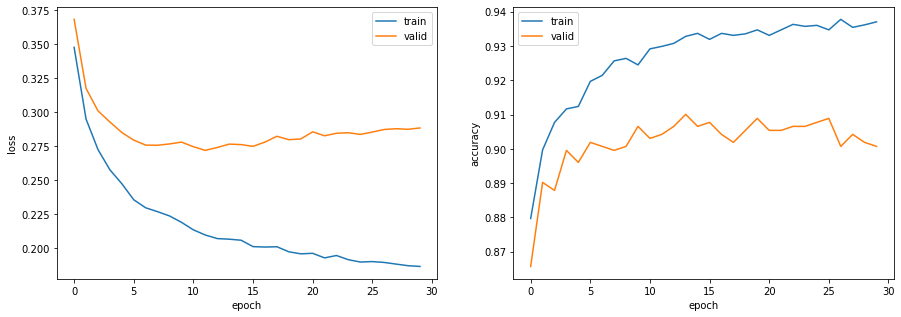

In [23]:
from matplotlib import pyplot as plt
import numpy as np

# 視覚化
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[1], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

# No76

In [24]:
# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# 最適化関数の定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# 学習
num_epochs = 30
log_train = []
log_valid = []
for epoch in range(num_epochs):
    #訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
        # 勾配を0に初期化
        optimizer.zero_grad()
        
        # 順伝播 + 誤差逆伝播 + 重み更新
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])
    
    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
    
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')
    

epoch: 1, loss_train: 0.3553, accuracy_train: 0.8747, loss_valid: 0.3508, accuracy_valid: 0.8715
epoch: 2, loss_train: 0.2957, accuracy_train: 0.9008, loss_valid: 0.3002, accuracy_valid: 0.8832
epoch: 3, loss_train: 0.2732, accuracy_train: 0.9105, loss_valid: 0.2819, accuracy_valid: 0.8949
epoch: 4, loss_train: 0.2561, accuracy_train: 0.9166, loss_valid: 0.2700, accuracy_valid: 0.9030
epoch: 5, loss_train: 0.2475, accuracy_train: 0.9150, loss_valid: 0.2678, accuracy_valid: 0.9054
epoch: 6, loss_train: 0.2371, accuracy_train: 0.9203, loss_valid: 0.2630, accuracy_valid: 0.9054
epoch: 7, loss_train: 0.2298, accuracy_train: 0.9219, loss_valid: 0.2610, accuracy_valid: 0.9112
epoch: 8, loss_train: 0.2250, accuracy_train: 0.9226, loss_valid: 0.2616, accuracy_valid: 0.9112
epoch: 9, loss_train: 0.2228, accuracy_train: 0.9264, loss_valid: 0.2616, accuracy_valid: 0.9030
epoch: 10, loss_train: 0.2159, accuracy_train: 0.9271, loss_valid: 0.2616, accuracy_valid: 0.9112
epoch: 11, loss_train: 0.2136

# No77

In [25]:
import time

def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):
    # dataloaderの作成
    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
    dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
    
    # 学習
    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        # 開始時刻の記録
        s_time = time.time()
        #訓練モードに設定
        model.train()
        for inputs, labels in dataloader_train:
            # 勾配を0に初期化
            optimizer.zero_grad()

            # 順伝播 + 誤差逆伝播 + 重み更新
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # 損失と正解率の算出
        loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])
        # チェックポイントの保存
        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
        
        # 終了時刻の記録
        e_time = time.time()
        
        # ログ出力
        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}')
    return {'train': log_train, 'valid': log_valid}

In [27]:
# datasetの作成
dataset_train = CreateDataset(X_train, y_train)
dataset_valid = CreateDataset(X_valid, y_valid)

# モデルの定義
model = SLPNet(300, 4)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# モデルの定義
for batch_size in [2 ** i for i in range(11)]:
    print(f'バッチサイズ: {batch_size}')
    log = train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, 1)

バッチサイズ: 1
epoch: 1, loss_train: 0.3504, accuracy_train: 0.8786, loss_valid: 0.3555, accuracy_valid: 0.8785
バッチサイズ: 2
epoch: 1, loss_train: 0.3130, accuracy_train: 0.8963, loss_valid: 0.3231, accuracy_valid: 0.8890
バッチサイズ: 4
epoch: 1, loss_train: 0.3028, accuracy_train: 0.8992, loss_valid: 0.3149, accuracy_valid: 0.8925
バッチサイズ: 8
epoch: 1, loss_train: 0.2970, accuracy_train: 0.9027, loss_valid: 0.3108, accuracy_valid: 0.8949
バッチサイズ: 16
epoch: 1, loss_train: 0.2948, accuracy_train: 0.9030, loss_valid: 0.3092, accuracy_valid: 0.8949
バッチサイズ: 32
epoch: 1, loss_train: 0.2939, accuracy_train: 0.9035, loss_valid: 0.3084, accuracy_valid: 0.8949
バッチサイズ: 64
epoch: 1, loss_train: 0.2933, accuracy_train: 0.9036, loss_valid: 0.3081, accuracy_valid: 0.8960
バッチサイズ: 128
epoch: 1, loss_train: 0.2921, accuracy_train: 0.9036, loss_valid: 0.3079, accuracy_valid: 0.8972
バッチサイズ: 256
epoch: 1, loss_train: 0.2929, accuracy_train: 0.9036, loss_valid: 0.3078, accuracy_valid: 0.8972
バッチサイズ: 512
epoch: 1, loss_tra

# No79

In [40]:
from torch.nn import functional as F

class MLPNet(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size) 
    self.bn = nn.BatchNorm1d(mid_size)

  def forward(self, x):
    x = F.relu(self.fc(x))
    for _ in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))

    return x

In [41]:
from torch import optim

def calculate_loss_and_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
#       inputs = inputs.to(device)
#       labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(loader), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送る
#   model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for inputs, labels in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
#       inputs = inputs.to(device)
#       labels = labels.to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}

In [42]:
# datasetの作成
dataset_train = CreateDataset(X_train, y_train)
dataset_valid = CreateDataset(X_valid, y_valid)

# モデルの定義
model = MLPNet(300, 200, 4, 1)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

# デバイスの指定
# device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, 64, model, criterion, optimizer, 1000)

epoch: 1, loss_train: 0.9618, accuracy_train: 0.7405, loss_valid: 0.9836, accuracy_valid: 0.7255, 0.3809sec
epoch: 2, loss_train: 0.7935, accuracy_train: 0.7710, loss_valid: 0.8124, accuracy_valid: 0.7675, 0.3461sec
epoch: 3, loss_train: 0.7060, accuracy_train: 0.7783, loss_valid: 0.7200, accuracy_valid: 0.7827, 0.3493sec
epoch: 4, loss_train: 0.6493, accuracy_train: 0.7872, loss_valid: 0.6608, accuracy_valid: 0.7909, 0.3478sec
epoch: 5, loss_train: 0.6018, accuracy_train: 0.7996, loss_valid: 0.6109, accuracy_valid: 0.8002, 0.3468sec
epoch: 6, loss_train: 0.5693, accuracy_train: 0.8098, loss_valid: 0.5767, accuracy_valid: 0.8178, 0.3564sec
epoch: 7, loss_train: 0.5380, accuracy_train: 0.8215, loss_valid: 0.5446, accuracy_valid: 0.8306, 0.3446sec
epoch: 8, loss_train: 0.5093, accuracy_train: 0.8293, loss_valid: 0.5153, accuracy_valid: 0.8400, 0.3327sec
epoch: 9, loss_train: 0.4890, accuracy_train: 0.8372, loss_valid: 0.4950, accuracy_valid: 0.8458, 0.3393sec
epoch: 10, loss_train: 0.468

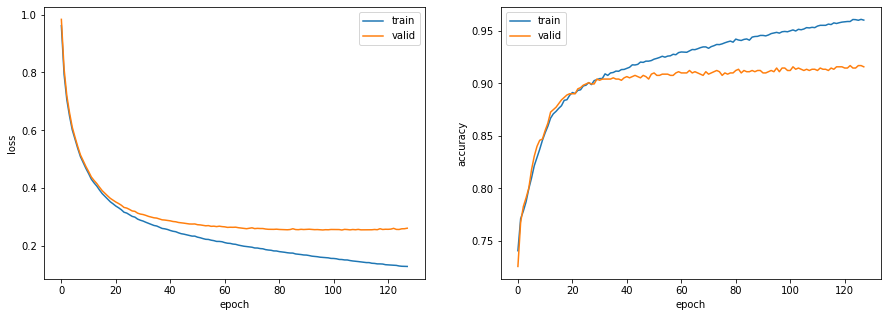

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(log['train']).T[0], label='train')
ax[0].plot(np.array(log['valid']).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log['train']).T[1], label='train')
ax[1].plot(np.array(log['valid']).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [47]:
def calculate_accuracy(model, loader):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
#       inputs = inputs.to(device)
#       labels = labels.to(device)
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return correct / total

In [48]:
# 正解率の確認
acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')

正解率（学習データ）：0.960
正解率（評価データ）：0.898
